<a href="https://colab.research.google.com/github/Bekamgenene/Elevvo-Internship-Program/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Upload your data file zipped folder**

In [1]:
from google.colab import files
import zipfile
import os
print("Upload your 'u.data' file or zipped folder containing it:")
uploaded = files.upload()
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        print(f"Unzipping {filename}...")
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('movielens_data')
        data_path = 'movielens_data/ml-100k/u.data'
    else:
        data_path = filename
print(f"Data file path: {data_path}")

Upload your 'u.data' file or zipped folder containing it:


Saving ml-100k.zip to ml-100k.zip
Unzipping ml-100k.zip...
Data file path: movielens_data/ml-100k/u.data


**Step 2: Load data and create user-item matrix**

Data shape: (100000, 4)
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
User -Item matrix shape: (943, 1682)


/tmp/ipython-input-1907759877.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=data, palette='viridis', legend=False)


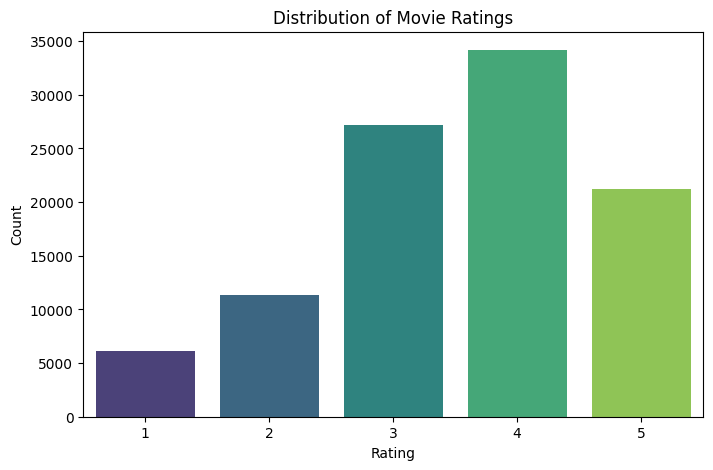

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

columns = ['user_id', 'movie_id', 'rating', 'timestamp']
data = pd.read_csv(data_path, sep='\t', names=columns)
print(f"Data shape: {data.shape}")
print(data.head())
user_item_matrix = data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
print(f"User -Item matrix shape: {user_item_matrix.shape}")

plt.figure(figsize=(8,5))
sns.countplot(x='rating', data=data, palette='viridis', legend=False)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**Step 3: Compute user similarity (cosine and Pearson)**

User   similarity matrices (cosine and Pearson) computed.


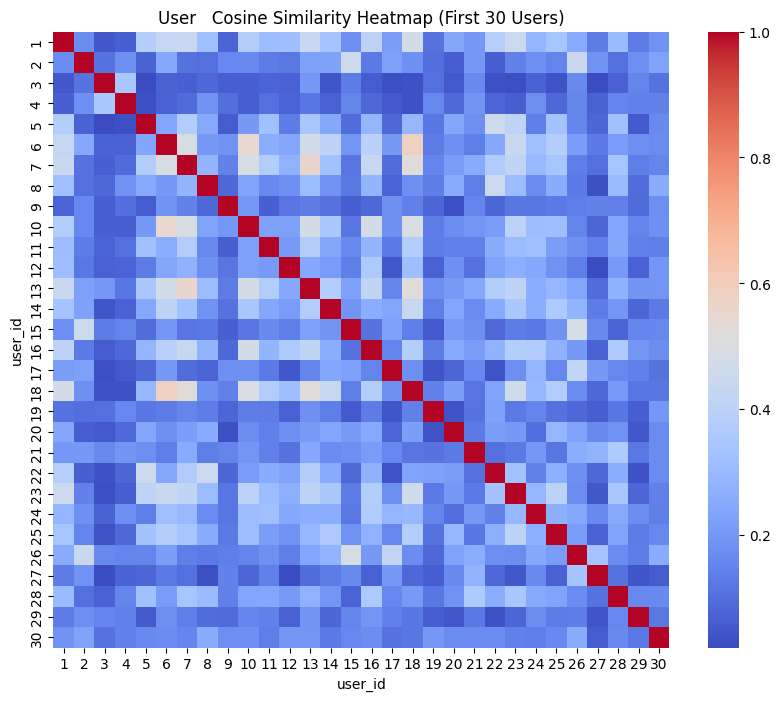

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
user_sim_cosine = cosine_similarity(user_item_matrix)
user_sim_cosine_df = pd.DataFrame(user_sim_cosine, index=user_item_matrix.index, columns=user_item_matrix.index)
user_sim_pearson_df = user_item_matrix.T.corr(method='pearson')
print("User   similarity matrices (cosine and Pearson) computed.")

plt.figure(figsize=(10,8))
sns.heatmap(user_sim_cosine_df.iloc[:30, :30], cmap='coolwarm', square=True)
plt.title('User   Cosine Similarity Heatmap (First 30 Users)')
plt.show()


**Step 4: User-based collaborative filtering recommendation**

In [5]:
def recommend_user_based(user_id, user_item_matrix, user_sim_df, top_n=10):
    if user_id not in user_item_matrix.index:
        print(f"User   {user_id} not found.")
        return []
    sim_scores = user_sim_df.loc[user_id]
    ratings = user_item_matrix
    weighted_ratings = ratings.T.dot(sim_scores) / sim_scores.sum()
    user_rated = ratings.loc[user_id]
    recommendations = weighted_ratings[user_rated == 0]
    top_recs = recommendations.sort_values(ascending=False).head(top_n)
    return top_recs.index.tolist()

**Step 5: Item-based collaborative filtering recommendation**

In [6]:
item_sim_cosine = cosine_similarity(user_item_matrix.T)
item_sim_cosine_df = pd.DataFrame(item_sim_cosine, index=user_item_matrix.columns, columns=user_item_matrix.columns)
def recommend_item_based(user_id, user_item_matrix, item_sim_df, top_n=10):
    if user_id not in user_item_matrix.index:
        print(f"User   {user_id} not found.")
        return []
    user_ratings = user_item_matrix.loc[user_id]
    scores = pd.Series(0, index=user_item_matrix.columns)
    for item, rating in user_ratings[user_ratings > 0].items():
        sim_scores = item_sim_df[item]
        scores += sim_scores * rating
    scores = scores[user_ratings == 0]
    top_recs = scores.sort_values(ascending=False).head(top_n)
    return top_recs.index.tolist()

**Step 6: Matrix Factorization (SVD) recommendation**

In [10]:
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

user_ratings_mean = user_item_matrix.mean(axis=1)
R_demeaned = user_item_matrix.sub(user_ratings_mean, axis=0)


R_demeaned_sparse = csr_matrix(R_demeaned.values)

U, sigma, Vt = svds(R_demeaned_sparse, k=20)
sigma = np.diag(sigma)
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.values.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=user_item_matrix.columns, index=user_item_matrix.index)

def recommend_svd(user_id, preds_df, user_item_matrix, top_n=10):
    if user_id not in preds_df.index:
        print(f"User   {user_id} not found.")
        return []
    user_row = preds_df.loc[user_id]
    user_data = user_item_matrix.loc[user_id]
    recommendations = user_row[user_data == 0]
    top_recs = recommendations.sort_values(ascending=False).head(top_n)
    return top_recs.index.tolist()

**Step 7: Train/test split for evaluation**

In [13]:
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

def train_test_split_user(data, test_size=0.2, random_state=42):
    train_list = []
    test_list = []
    for user in data['user_id'].unique():
        user_data = data[data['user_id'] == user]
        train, test = train_test_split(user_data, test_size=test_size, random_state=random_state)
        train_list.append(train)
        test_list.append(test)
    train_data = pd.concat(train_list)
    test_data = pd.concat(test_list)
    return train_data, test_data

train_data, test_data = train_test_split_user(data)
train_matrix = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
train_user_sim_cosine = cosine_similarity(train_matrix)
train_user_sim_cosine_df = pd.DataFrame(train_user_sim_cosine, index=train_matrix.index, columns=train_matrix.index)
train_user_sim_pearson_df = train_matrix.T.corr(method='pearson')
train_item_sim_cosine = cosine_similarity(train_matrix.T)
train_item_sim_cosine_df = pd.DataFrame(train_item_sim_cosine, index=train_matrix.columns, columns=train_matrix.columns)
train_user_ratings_mean = train_matrix.mean(axis=1)
R_train_demeaned = train_matrix.sub(train_user_ratings_mean, axis=0)

R_train_demeaned_sparse = csr_matrix(R_train_demeaned.values)

U_train, sigma_train, Vt_train = svds(R_train_demeaned_sparse, k=20)
sigma_train = np.diag(sigma_train)
all_user_predicted_ratings_train = np.dot(np.dot(U_train, sigma_train), Vt_train) + train_user_ratings_mean.values.reshape(-1, 1)
preds_train_df = pd.DataFrame(all_user_predicted_ratings_train, columns=train_matrix.columns, index=train_matrix.index)

**Step 8: Precision@K evaluation function**

In [14]:
def precision_at_k(user_id, train_matrix, test_data, user_sim_df, k=10, method='user'):
    if method == 'user':
        recs = recommend_user_based(user_id, train_matrix, user_sim_df, top_n=k)
    elif method == 'item':
        recs = recommend_item_based(user_id, train_matrix, train_item_sim_cosine_df, top_n=k)
    elif method == 'svd':
        recs = recommend_svd(user_id, preds_train_df, train_matrix, top_n=k)
    else:
        raise ValueError("Method must be 'user', 'item', or 'svd'")

    if len(recs) == 0:
        return 0.0

    actual_movies = test_data[test_data['user_id'] == user_id]['movie_id'].tolist()
    hits = sum([1 for movie in recs if movie in actual_movies])
    precision = hits / k
    return precision

**Step 9: Evaluate all methods on sample users**


In [15]:
sample_users = train_matrix.index[:20]
precisions_user_cosine = []
precisions_user_pearson = []
precisions_item = []
precisions_svd = []
for user in sample_users:
    p_user_cos = precision_at_k(user, train_matrix, test_data, train_user_sim_cosine_df, k=10, method='user')
    p_user_pear = precision_at_k(user, train_matrix, test_data, train_user_sim_pearson_df, k=10, method='user')
    p_item = precision_at_k(user, train_matrix, test_data, train_user_sim_cosine_df, k=10, method='item')
    p_svd = precision_at_k(user, train_matrix, test_data, train_user_sim_cosine_df, k=10, method='svd')

    precisions_user_cosine.append(p_user_cos)
    precisions_user_pearson.append(p_user_pear)
    precisions_item.append(p_item)
    precisions_svd.append(p_svd)


print(f"Average Precision@10 (User  -based Cosine): {np.mean(precisions_user_cosine):.4f}")
print(f"Average Precision@10 (User  -based Pearson): {np.mean(precisions_user_pearson):.4f}")
print(f"Average Precision@10 (Item-based Cosine): {np.mean(precisions_item):.4f}")
print(f"Average Precision@10 (Matrix Factorization SVD): {np.mean(precisions_svd):.4f}")


Average Precision@10 (User  -based Cosine): 0.3350
Average Precision@10 (User  -based Pearson): 0.3800
Average Precision@10 (Item-based Cosine): 0.3800
Average Precision@10 (Matrix Factorization SVD): 0.4050


/tmp/ipython-input-2099879752.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=methods, y=avg_precisions, palette='magma')


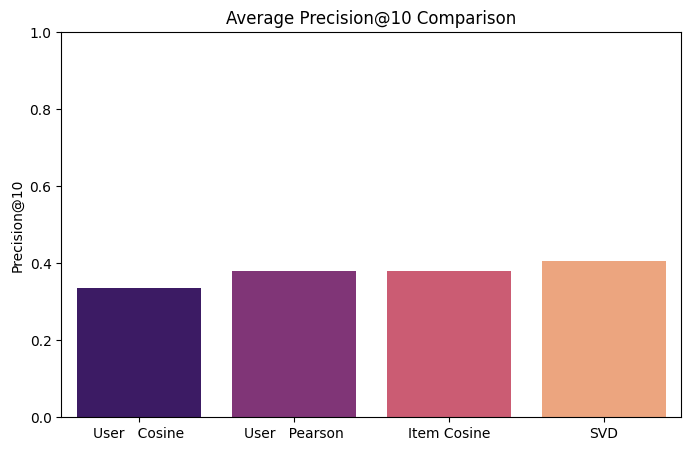

In [16]:
methods = ['User   Cosine', 'User   Pearson', 'Item Cosine', 'SVD']
avg_precisions = [np.mean(precisions_user_cosine), np.mean(precisions_user_pearson), np.mean(precisions_item), np.mean(precisions_svd)]
plt.figure(figsize=(8,5))
sns.barplot(x=methods, y=avg_precisions, palette='magma')
plt.title('Average Precision@10 Comparison')
plt.ylabel('Precision@10')
plt.ylim(0, 1)
plt.show()

**Step 10: Example recommendations for user 1**

In [17]:
print("\nExample recommendations for user 1:")
user1_user_cosine = recommend_user_based(1, user_item_matrix, user_sim_cosine_df, top_n=10)
user1_user_pearson = recommend_user_based(1, user_item_matrix, user_sim_pearson_df, top_n=10)
user1_item_cosine = recommend_item_based(1, user_item_matrix, item_sim_cosine_df, top_n=10)
user1_svd = recommend_svd(1, preds_df, user_item_matrix, top_n=10)
print("User  -based CF (Cosine):", user1_user_cosine)
print("User  -based CF (Pearson):", user1_user_pearson)
print("Item-based CF (Cosine):", user1_item_cosine)
print("Matrix Factorization (SVD):", user1_svd)


Example recommendations for user 1:
User  -based CF (Cosine): [318, 423, 357, 286, 288, 483, 405, 294, 496, 655]
User  -based CF (Pearson): [318, 423, 357, 483, 286, 288, 405, 496, 655, 294]
Item-based CF (Cosine): [423, 655, 568, 403, 385, 318, 357, 367, 393, 433]
Matrix Factorization (SVD): [475, 423, 318, 403, 433, 275, 483, 286, 408, 655]


/tmp/ipython-input-1533926212.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user1_svd, y=user1_predicted_scores.values, palette='viridis')


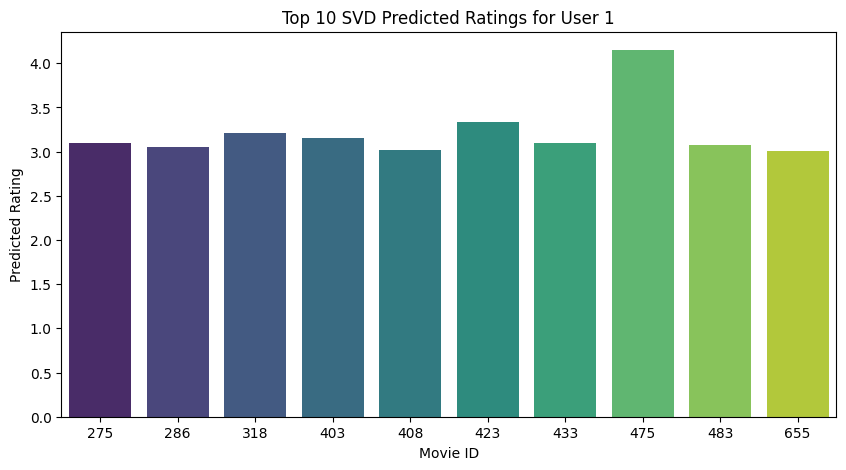

In [18]:
user1_predicted_scores = preds_df.loc[1, user1_svd]
plt.figure(figsize=(10,5))
sns.barplot(x=user1_svd, y=user1_predicted_scores.values, palette='viridis')
plt.title('Top 10 SVD Predicted Ratings for User 1')
plt.xlabel('Movie ID')
plt.ylabel('Predicted Rating')
plt.show()


                          **ThANK YOU**

